In [1]:
import numpy as np
import sys
sys.path.append('/home/yungdankblast/Desktop/Research/delay-optimizer')
from DelayEffects.Analyzer_new import FuncOpt
from Optimizer_Scripts.DelayTypeGenerators import *
import os
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
# Initialize
loss_name = 'Rosenbrock'
dimensions = [2, 10, 100, 1000]
rosen = {d: FuncOpt(loss_name, d) for d in dimensions}

In [93]:
# Read params
params = pd.read_csv("../hyperparameter_data.csv")

## Helper Functions

In [4]:
def parse(args):
    new_params = params.copy()
    for arg, val in args.items():
        new_params = new_params[new_params[arg] == val]
        
    return new_params

def validate(analyzer, args, num_params=5, num_points=200, drop_cols=None, verbose=False):
    # Initialize
    if drop_cols is None:
        drop_cols = ["loss_name", "dim", "use_delays", "max_L", "constant_learning_rate", "learning_rate", 
                 "min_val", "max_val", "num_delays", "maxiter", "optimizer_name", "tol", "max_evals",
                 "symmetric_delays", "num_tests", "print_log", "vary_percent", "hyper_minimize", "clip_grad",
                 "clip_val", "num_test_initials", "test_time", "num_initial_values"]
    delayed = args['use_delays']
    
    # Parse hyperparameters
    parsed = parse(args)
    parsed = parsed.drop(columns=drop_cols)
    parsed = parsed.sort_values('best_loss')
    
    # Extract params
    vals = parsed.loc[:,['max_learning_rate', 'min_learning_rate', 'step_size']].values
    if len(vals) > num_params:
        vals = vals[:num_params]
    
    # Add control params
    vals = np.vstack(([[2.98, 0.23, 740.]], vals))
    
    analyzer.initialize_points(num_points, 'random')
    mean_losses = []
    for i, params in enumerate(vals):
        if delayed is True:
            analyzer.del_params = {'max_learning_rate': params[0], 'min_learning_rate': params[1], 
                                   'step_size': params[2]}
        else:
            analyzer.params = {'max_learning_rate': params[0], 'min_learning_rate': params[1], 
                                   'step_size': params[2]}
        analyzer.calculate_save_values(delayed)
        
        if delayed is True:
            conv = analyzer.del_conv
        else:
            conv = analyzer.conv
            
        mean_losses.append(np.mean(analyzer.extract_values(delayed, 'loss')[1]))
        
    return vals, mean_losses
            
            
def results(vals, mean_losses): 
    i = np.argmin(mean_losses)
    best_params = np.round(vals[i], 2)
    worst = np.argwhere(mean_losses > mean_losses[0]).ravel()
    
    return float("%.3g" % mean_losses[i]), best_params, i, worst
        
def plot_val(mean_losses):
    ind = np.arange(len(mean_losses))
    ticks = [i for i in ind]
    ticks[0] = "Control"
    plt.bar(ind, mean_losses, tick_label=ticks, color='C2')
    plt.ylabel("Mean Loss")
    plt.show()
    
def drop_params(loss_name, max_learning_rate, min_learning_rate, step_size):
    new_params = params.copy()
    new_params = new_params[new_params["loss_name"]==loss_name]
    new_params = new_params[new_params["max_learning_rate"]==max_learning_rate]
    new_params = new_params[new_params["min_learning_rate"]==min_learning_rate]
    new_params = new_params[new_params["step_size"]==step_size]
    if len(new_params.index) > 0:
        index = new_params.index[0]
        return params.drop(index)
    else:
        return params

In [5]:
num_tests = 5
num_points = 250
num_params = 8

# Undelayed

In [6]:
# 2d undelayed
args = {"loss_name":'Rosenbrock', "dim":2, "use_delays":False, "constant_learning_rate":False}

good_ind = []
bad_ind = []
best_losses = []

for j in range(num_tests):
    vals, mean_losses = validate(rosen2d, args, num_params, num_points)
    best_loss, best_params, i, worse_ind = results(vals, mean_losses)
    bad_ind = bad_ind + list(worse_ind)
    good_ind.append(i)
    best_losses.append(best_loss)
    
print("Best Losses:", best_losses)
print("Best Params Indices:", {ind:good_ind.count(ind) for ind in good_ind})
print("Worse than Control:", {ind:bad_ind.count(ind) for ind in bad_ind})

Best Losses: [0.259, 0.405, 0.406, 0.313, 0.433]
Best Params Indices: {4: 3, 6: 2}
Worse than Control: {}


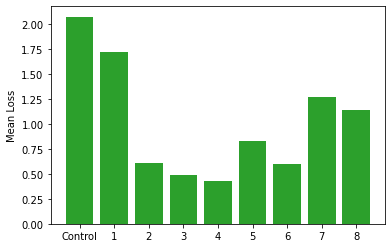

In [7]:
plot_val(mean_losses)

In [8]:
print(vals[4])
print(vals[6])

[3.15608865e+00 7.79224530e-01 2.30000000e+03]
[2.92068270e+00 5.72766857e-01 2.00000000e+03]


In [ ]:
# No Params dropped for 2d

In [10]:
# 10d undelayed
args = {"loss_name":'Rosenbrock', "dim":10, "use_delays":False, "constant_learning_rate":False}

good_ind = []
bad_ind = []
best_losses = []

for j in range(num_tests):
    vals, mean_losses = validate(rosen10d, args, num_params, num_points)
    best_loss, best_params, i, worse_ind = results(vals, mean_losses)
    bad_ind = bad_ind + list(worse_ind)
    good_ind.append(i)
    best_losses.append(best_loss)
    
print("Best Losses:", best_losses)
print("Best Params Indices:", {ind:good_ind.count(ind) for ind in good_ind})
print("Worse than Control:", {ind:bad_ind.count(ind) for ind in bad_ind})

Best Losses: [3.4, 4.26, 4.08, 3.83, 3.98]
Best Params Indices: {4: 4, 3: 1}
Worse than Control: {5: 5, 6: 5, 7: 5, 1: 1, 2: 1, 8: 1}


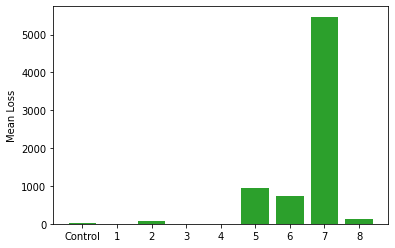

In [11]:
plot_val(mean_losses)

In [12]:
print(vals[4])
print(vals[3])

[3.18381112e+00 6.16600538e-01 1.30000000e+03]
[2.48814587e+00 6.31154467e-01 9.00000000e+02]


In [10]:
# OLD - dropped 5,6,7,8
params = drop_params('Rosenbrock', vals[5][0], vals[5][1], vals[5][2])
params = drop_params('Rosenbrock', vals[6][0], vals[6][1], vals[6][2])
params = drop_params('Rosenbrock', vals[7][0], vals[7][1], vals[7][2])

In [11]:
# 100d undelayed
args = {"loss_name":'Rosenbrock', "dim":100, "use_delays":False, "constant_learning_rate":False}

good_ind = []
bad_ind = []
best_losses = []

for j in range(num_tests):
    vals, mean_losses = validate(rosen100d, args, num_params, num_points)
    best_loss, best_params, i, worse_ind = results(vals, mean_losses)
    bad_ind = bad_ind + list(worse_ind)
    good_ind.append(i)
    best_losses.append(best_loss)
    
print("Best Losses:", best_losses)
print("Best Params Indices:", {ind:good_ind.count(ind) for ind in good_ind})
print("Worse than Control:", {ind:bad_ind.count(ind) for ind in bad_ind})

Best Losses: [105.0, 102.0, 104.0, 109.0, 106.0]
Best Params Indices: {5: 5}
Worse than Control: {4: 4, 7: 3, 2: 1}


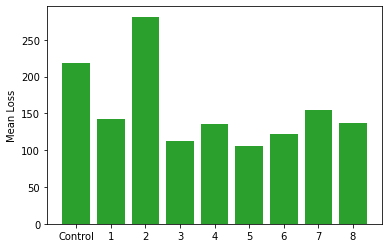

In [12]:
plot_val(mean_losses)

In [13]:
print(vals[5])

[3.72809970e+00 3.69316824e-01 4.00000000e+02]


In [ ]:
# OLD - dropped 4,7
params = drop_params('Rosenbrock', vals[4][0], vals[4][1], vals[4][2])
params = drop_params('Rosenbrock', vals[7][0], vals[7][1], vals[7][2])

In [6]:
# 1000d undelayed
args = {"loss_name":'Rosenbrock', "dim":1000, "use_delays":False, "constant_learning_rate":False}

good_ind = []
bad_ind = []
best_losses = []

for j in range(num_tests):
    vals, mean_losses = validate(rosen1000d, args, num_params, num_points)
    best_loss, best_params, i, worse_ind = results(vals, mean_losses)
    bad_ind = bad_ind + list(worse_ind)
    good_ind.append(i)
    best_losses.append(best_loss)
    
print("Best Losses:", best_losses)
print("Best Params Indices:", {ind:good_ind.count(ind) for ind in good_ind})
print("Worse than Control:", {ind:bad_ind.count(ind) for ind in bad_ind})

Best Losses: [1010.0, 1020.0, 1160.0, 1010.0, 1020.0]
Best Params Indices: {1: 5}
Worse than Control: {2: 4, 3: 5, 8: 5}


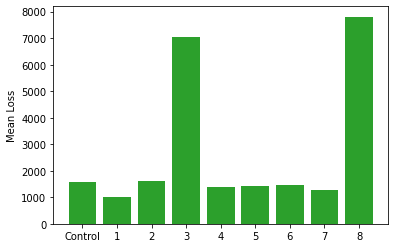

In [7]:
plot_val(mean_losses)

In [8]:
print(vals[1])

[2.73894202e+00 4.84864864e-01 1.40000000e+03]


In [9]:
# OLD - dropped 2,3,8
params = drop_params('Rosenbrock', vals[2][0], vals[2][1], vals[2][2])
params = drop_params('Rosenbrock', vals[3][0], vals[3][1], vals[3][2])
params = drop_params('Rosenbrock', vals[8][0], vals[8][1], vals[8][2])

# Max Delay of 1

In [10]:
# 2d max_L=1
args = {"loss_name":'Rosenbrock', "dim":2, "use_delays":True, "max_L":1, "constant_learning_rate":False}

good_ind = []
bad_ind = []
best_losses = []

for j in range(num_tests):
    vals, mean_losses = validate(rosen2d, args, num_params, num_points)
    best_loss, best_params, i, worse_ind = results(vals, mean_losses)
    bad_ind = bad_ind + list(worse_ind)
    good_ind.append(i)
    best_losses.append(best_loss)
    
print("Best Losses:", best_losses)
print("Best Params Indices:", {ind:good_ind.count(ind) for ind in good_ind})
print("Worse than Control:", {ind:bad_ind.count(ind) for ind in bad_ind})

Best Losses: [2.01, 1.97, 2.47, 1.88, 2.02]
Best Params Indices: {6: 2, 2: 3}
Worse than Control: {3: 3, 8: 2}


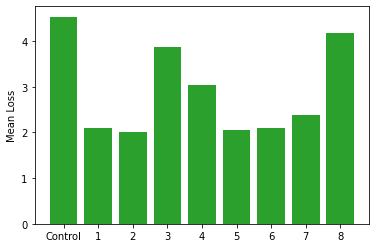

In [11]:
plot_val(mean_losses)

In [12]:
print(vals[2])
print(vals[6])

[  2.04803481   0.82461877 300.        ]
[  2.22075156   0.80964885 400.        ]


In [13]:
# OLD - dropped 3,8
params = drop_params('Rosenbrock', vals[3][0], vals[3][1], vals[3][2])
params = drop_params('Rosenbrock', vals[8][0], vals[8][1], vals[8][2])

In [14]:
# 10d max_L=1
args = {"loss_name":'Rosenbrock', "dim":10, "use_delays":True, "max_L":1, "constant_learning_rate":False}

good_ind = []
bad_ind = []
best_losses = []

for j in range(num_tests):
    vals, mean_losses = validate(rosen10d, args, num_params, num_points)
    best_loss, best_params, i, worse_ind = results(vals, mean_losses)
    bad_ind = bad_ind + list(worse_ind)
    good_ind.append(i)
    best_losses.append(best_loss)
    
print("Best Losses:", best_losses)
print("Best Params Indices:", {ind:good_ind.count(ind) for ind in good_ind})
print("Worse than Control:", {ind:bad_ind.count(ind) for ind in bad_ind})

Best Losses: [5.76, 5.7, 6.57, 6.24, 5.74]
Best Params Indices: {7: 3, 4: 2}
Worse than Control: {2: 4, 5: 5, 6: 2, 3: 1, 7: 1}


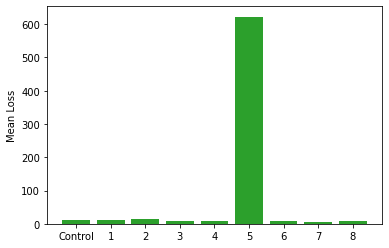

In [15]:
plot_val(mean_losses)

In [17]:
print(vals[7])
print(vals[4])

[1.35968990e+00 9.44716406e-01 2.40000000e+03]
[2.51964522e+00 4.18477608e-01 1.40000000e+03]


In [18]:
# OLD - dropped 2,5
params = drop_params('Rosenbrock', vals[2][0], vals[2][1], vals[2][2])
params = drop_params('Rosenbrock', vals[5][0], vals[5][1], vals[5][2])

In [19]:
# 100d max_L=1
args = {"loss_name":'Rosenbrock', "dim":100, "use_delays":True, "max_L":1, "constant_learning_rate":False}

good_ind = []
bad_ind = []
best_losses = []

for j in range(num_tests):
    vals, mean_losses = validate(rosen100d, args, num_params, num_points)
    best_loss, best_params, i, worse_ind = results(vals, mean_losses)
    bad_ind = bad_ind + list(worse_ind)
    good_ind.append(i)
    best_losses.append(best_loss)
    
print("Best Losses:", best_losses)
print("Best Params Indices:", {ind:good_ind.count(ind) for ind in good_ind})
print("Worse than Control:", {ind:bad_ind.count(ind) for ind in bad_ind})

Best Losses: [98.7, 98.4, 98.5, 100.0, 100.0]
Best Params Indices: {4: 5}
Worse than Control: {1: 5, 2: 5, 3: 5, 5: 5, 7: 5}


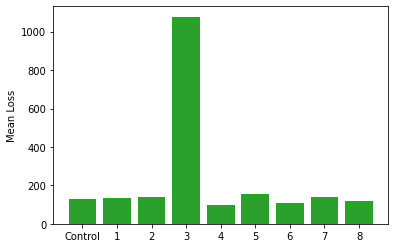

In [20]:
plot_val(mean_losses)

In [21]:
print(vals[4])

[1.96106227e+00 7.11081596e-01 8.00000000e+02]


In [ ]:
# OLD - dropped 1,2,3,5,7
params = drop_params('Rosenbrock', vals[1][0], vals[1][1], vals[1][2])
params = drop_params('Rosenbrock', vals[2][0], vals[2][1], vals[2][2])
params = drop_params('Rosenbrock', vals[3][0], vals[3][1], vals[3][2])
params = drop_params('Rosenbrock', vals[5][0], vals[5][1], vals[5][2])
params = drop_params('Rosenbrock', vals[7][0], vals[7][1], vals[7][2])

In [6]:
# 1000d max_L=1
args = {"loss_name":'Rosenbrock', "dim":1000, "use_delays":True, "max_L":1, "constant_learning_rate":False}

good_ind = []
bad_ind = []
best_losses = []

for j in range(num_tests):
    vals, mean_losses = validate(rosen1000d, args, num_params, num_points)
    best_loss, best_params, i, worse_ind = results(vals, mean_losses)
    bad_ind = bad_ind + list(worse_ind)
    good_ind.append(i)
    best_losses.append(best_loss)
    
print("Best Losses:", best_losses)
print("Best Params Indices:", {ind:good_ind.count(ind) for ind in good_ind})
print("Worse than Control:", {ind:bad_ind.count(ind) for ind in bad_ind})

Best Losses: [1010.0, 1010.0, 1000.0, 1010.0, 1010.0]
Best Params Indices: {8: 5}
Worse than Control: {2: 1, 4: 5, 5: 5, 6: 5}


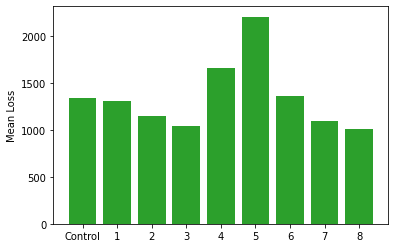

In [7]:
plot_val(mean_losses)

In [8]:
print(vals[8])

[3.60302764e+00 6.93843352e-01 1.30000000e+03]


In [9]:
# OLD - dropped 1,2,3,5,7
params = drop_params('Rosenbrock', vals[4][0], vals[4][1], vals[4][2])
params = drop_params('Rosenbrock', vals[5][0], vals[5][1], vals[5][2])
params = drop_params('Rosenbrock', vals[6][0], vals[6][1], vals[6][2])

In [18]:
params = np.array([
    ['Rosenbrock', 2, False, 0, 3.1561, 0.7792, 2300.0],     
    ['Rosenbrock', 10, False, 0, 3.1838, 0.6166, 1300.0],    
    ['Rosenbrock', 100, False, 0, 3.7281, 0.3693, 400.0],   
    ['Rosenbrock', 1000, False, 0, 2.7389, 0.4849, 1400.0], 
    ['Rosenbrock', 2, True, 1, 2.048, 0.8246, 300.0],        
    ['Rosenbrock', 10, True, 1, 2.8954, 0.6782, 800.0],       
    ['Rosenbrock', 100, True, 1, 1.9611, 0.7111, 800.0],   
    ['Rosenbrock', 1000, True, 1, 3.603, 0.6938, 1300.0],    
])

In [57]:
test_params1 = {"max_learning_rate": 0.7272911920903335, "min_learning_rate": 1.3592428034693642, "step_size": 1100}
test_params2 = {"max_learning_rate": 0.23025270939641995, "min_learning_rate": 1.1707706451588509, "step_size": 1000}
test_params3 = {"max_learning_rate": 0.6263562546369942, "min_learning_rate": 1.4933742467660291, "step_size": 1300}
test_params4 = {"max_learning_rate": 0.3558298929567429, "min_learning_rate": 1.43892877896833, "step_size": 1200}
test_params5 = {"max_learning_rate": 1.51948837913446, "min_learning_rate": 0.42576586191473864, "step_size": 2100}
params = [test_params1, test_params2, test_params3, test_params4, test_params5]

In [71]:
d = 100
rosen[d].initialize_points('random', 1000)

In [72]:
for i, test_params in enumerate(params):
    if i not in [0,1,3]:
        continue
    rosen[d].optimize(Uniform(1,1000), param_type='given', **test_params)
    print(i, ":", rosen[d].get_mean_final(rosen[d].loss_vals))

0 : 99.66099560463648
1 : 96.75825827732018
3 : 97.56341927236174


In [ ]:
1, 1, 3,, 1, 0,, 1,, 1

In [ ]:
test_params1 = {"min_learning_rate": 0.7272911920903335, "max_learning_rate": 1.3592428034693642, "step_size": 1100}
test_params2 = {"min_learning_rate": 0.23025270939641995, "max_learning_rate": 1.1707706451588509, "step_size": 1000}
test_params3 = {"min_learning_rate": 0.6263562546369942, "max_learning_rate": 1.4933742467660291, "step_size": 1300}
test_params4 = {"min_learning_rate": 0.3558298929567429, "max_learning_rate": 1.43892877896833, "step_size": 1200}
test_params5 = {"max_learning_rate": 1.51948837913446, "min_learning_rate": 0.42576586191473864, "step_size": 2100}
params = [test_params1, test_params2,test_params3,test_params4, test_params5]

In [26]:
for i, test_params in enumerate(params):
    rosen[d].optimize(Uniform(1,1000), param_type='given', **test_params)
    print(i, ":", rosen[d].get_mean_final(rosen[d].loss_vals))

0 : 1.7157726596802232
1 : 3.4114983154259537
2 : 1.8883538085551699
3 : 2.727053382216298
4 : 2.4891788263795362


In [ ]:
0, 0, 0, 000